In [1]:
!pip install scorecardpy
!pip install autogluon.tabular
!pip install scikit-learn==1.2
!pip install "ray>=2.10.0,<2.45.0"
!pip install optuna-integration[lightgbm]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.7-py3-none-any.whl size=60629 sha256=18623438a8983bbb9df6fa2ed603c1a776acae2fde1a7bd6113dc1a13b28047a
  Stored in directory: /root/.cache/pip/wheels/68/88/65/58d6aa058698c47d7a24352952ea07a1409cc2eff3a8087c0c
Successfully built scorecardpy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: psutil
    Found existing installation: psutil 7.1.0
    Uninstalling psutil-7.

In [2]:
import numpy as np
import pandas as pd
import gc
import os
import time
from contextlib import contextmanager
import gc
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py  # 若不需要交互图，可注释掉
import scorecardpy as sc     # 风控分析常用分箱、WOE、IV
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold,train_test_split,KFold,cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
import optuna
from optuna import Trial
import lightgbm as lgb
# ================== Pandas显示设置 ==================
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.6f}'.format)
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Timer function
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# One-hot encoder with missing value handling
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']

    for col in categorical_columns:
        df[col] = df[col].fillna('MISSING')

    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


# Function to clean numerical columns
def clean_numerical_data(df, numerical_columns):
    df_clean = df.copy()

    for col in numerical_columns:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].replace([np.inf, -np.inf], np.nan)
            if df_clean[col].isnull().any():
                median_val = df_clean[col].median()
                df_clean[col] = df_clean[col].fillna(median_val)

    return df_clean


def _safe_div(numer, denom):
    """Safe element-wise division returning a Pandas Series."""
    numer = pd.Series(numer)
    denom = pd.Series(denom)
    result = np.nan
    with np.errstate(divide='ignore', invalid='ignore'):
        result = numer / denom
        result[(denom == 0) | denom.isna()] = np.nan
    return result


# Label encoding helper
def label_encode_categoricals(df):
    df_encoded = df.copy()
    cat_cols = [col for col in df_encoded.columns if df_encoded[col].dtype == 'object']
    label_info = {}  # 保存每列的唯一值个数

    for col in cat_cols:
        le = LabelEncoder()
        df_encoded[col] = df_encoded[col].astype(str).fillna('MISSING')
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_info[col] = len(le.classes_)  # 记录该列类别数

    return df_encoded, label_info

def safe_mode(series):
    """Return mode if available, else NaN."""
    try:
        mode_vals = series.mode()
        return mode_vals.iloc[0] if not mode_vals.empty else np.nan
    except Exception:
        return np.nan

**Feature Engineering**

In [4]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    # Read train, test, and external feature data
    df = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv', nrows=num_rows)
    testdata = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv', nrows=num_rows)
    previousdata = pd.read_csv('/kaggle/input/feature/krakowlublinzhabinka_feats.csv')
    print(f"Train samples: {len(df)}, test samples: {len(testdata)}")

    # Concatenate train and test vertically, then add extra feature set horizontally
    df = pd.concat([df, testdata], ignore_index=True)
    df = pd.concat([df, previousdata], axis=1)

    # Remove the 4 rows with invalid gender code "XNA"
    df = df[df['CODE_GENDER'] != 'XNA']

    # Binary categorical features (two unique values) - factorized to 0/1
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # Replace One-Hot encoding with Label Encoding for all remaining categorical features
    df, label_info = label_encode_categoricals(df)

    # Replace 365243 with NaN in DAYS_EMPLOYED (invalid placeholder)
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

    # === Feature engineering ===
    # Employment days to age ratio — proportion of life spent working
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

    # Total income to credit ratio — lower ratio = higher debt burden
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']

    # Income per family member — indicates economic pressure
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']

    # Annuity to income ratio — repayment burden from income
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

    # Annuity to credit ratio — repayment speed
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    # Credit amount minus total income — over-borrowing indicator
    df['CREDIT_INCOME_DIFF'] = df['AMT_CREDIT'] - df['AMT_INCOME_TOTAL']

    # Approximate loan term — how long to repay the credit
    df['CREDIT_TERM'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']

    # Income per child (+1 avoids division by zero)
    df['INCOME_PER_CHILD'] = df['AMT_INCOME_TOTAL'] / (df['CNT_CHILDREN'] + 1)

    # Credit to goods price ratio — checks if loan exceeds product cost
    df['CREDIT_GOODS_PERC'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']

    # Employment length to age ratio — career stability
    df['EMPLOY_TO_AGE_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

    # Children to family members ratio — dependency load
    df['CHILDREN_RATIO'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']

    # Car age relative to person’s age (years)
    df['CAR_AGE_RATIO'] = df['OWN_CAR_AGE'] / (-df['DAYS_BIRTH'] / 365)

    # Binary flag — owns both car and house
    df['REALTY_AND_CAR_FLAG'] = df['FLAG_OWN_CAR'] * df['FLAG_OWN_REALTY']

    # Log-transformed income — reduces skewness
    df['LOG_INCOME'] = np.log1p(df['AMT_INCOME_TOTAL'])

    # Log-transformed credit amount — reduces outlier impact
    df['LOG_CREDIT'] = np.log1p(df['AMT_CREDIT'])

    # Total lifetime earnings approximation (income × employment days)
    df['INCOME_X_EMPLOY'] = df['AMT_INCOME_TOTAL'] * (-df['DAYS_EMPLOYED'])

    # Credit amount multiplied by family size — household debt load
    df['CREDIT_X_FAMILY'] = df['AMT_CREDIT'] * df['CNT_FAM_MEMBERS']

    # Credit per child — child-related debt pressure
    df['CREDIT_PER_CHILD'] = df['AMT_CREDIT'] / (df['CNT_CHILDREN'] + 1)

    # Mark train vs test samples
    df['is_train'] = 0
    df.loc[:len(pd.read_csv('../input/home-credit-default-risk/application_train.csv')) - 1, 'is_train'] = 1

    # Clean up temporary data
    del testdata
    del previousdata
    gc.collect()

    print(f"Label-encoded categorical features: {len(label_info)} columns processed.")
    return df

In [5]:
# Preprocess bureau.csv and bureau_balance.csv
def safe_mode(series):
    """Return mode if available, else NaN."""
    try:
        mode_vals = series.mode()
        return mode_vals.iloc[0] if not mode_vals.empty else np.nan
    except Exception:
        return np.nan


def bureau_and_balance(num_rows=None, nan_as_category=True):
    """
    Safe and stable version of bureau_and_balance():
    - Keeps original string values of CREDIT_ACTIVE (for Active/Closed split)
    - Performs label encoding on other categorical columns
    - Aggregates numeric and categorical features
    - Adds derived ratio and recency features
    """
    import pandas as pd
    import numpy as np
    import gc

    # === Load raw data ===
    bureaudata = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv', nrows=num_rows)
    balancedata = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau_balance.csv', nrows=num_rows)
    print(f"📄 Bureau raw shape: {bureaudata.shape}, Bureau_balance raw shape: {balancedata.shape}")

    # === Backup original CREDIT_ACTIVE column before encoding ===
    bureau_cat_backup = {}
    if 'CREDIT_ACTIVE' in bureaudata.columns:
        bureau_cat_backup['CREDIT_ACTIVE'] = bureaudata['CREDIT_ACTIVE'].copy()

    # === Encode and aggregate bureau_balance ===
    balancedata, bb_label_info = label_encode_categoricals(balancedata)

    bb_num_agg = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'size']}
    bb_cat_agg = {}
    for col, n_unique in bb_label_info.items():
        if n_unique == 2:
            bb_cat_agg[col] = ['mean']
        elif n_unique > 2:
            bb_cat_agg[col] = [safe_mode]

    balancedata_aggregated = balancedata.groupby('SK_ID_BUREAU').agg({**bb_num_agg, **bb_cat_agg})
    balancedata_aggregated.columns = pd.Index([
        f"BB_{col[0]}_BINARY_MEAN" if col[1] == 'mean' and bb_label_info.get(col[0], 0) == 2
        else (f"BB_{col[0]}_MODE" if col[1] == 'safe_mode' or 'lambda' in col[1] else f"BB_{col[0]}_{col[1].upper()}")
        for col in balancedata_aggregated.columns
    ])
    print(f"✅ Bureau balance aggregated shape: {balancedata_aggregated.shape}")

    # === Merge aggregated bureau_balance with bureau ===
    bureaudata = bureaudata.join(balancedata_aggregated, how='left', on='SK_ID_BUREAU')
    del balancedata, balancedata_aggregated
    gc.collect()

    # === Label encode bureau (excluding CREDIT_ACTIVE) ===
    bureau_encoded, bureau_label_info = label_encode_categoricals(
        bureaudata.drop(columns=['CREDIT_ACTIVE'], errors='ignore')
    )

    # Restore original CREDIT_ACTIVE strings for Active/Closed filtering
    if 'CREDIT_ACTIVE' in bureaudata.columns:
        bureau_encoded['CREDIT_ACTIVE'] = bureau_cat_backup['CREDIT_ACTIVE']

    bureaudata = bureau_encoded

    # === Define numeric aggregations ===
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var', 'median'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean', 'var', 'median'],
        'DAYS_CREDIT_UPDATE': ['mean', 'min', 'max', 'var'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean', 'sum', 'var', 'median'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max', 'sum', 'var'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum', 'var', 'median'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum', 'var', 'median'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'max', 'sum', 'var'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum', 'max', 'var', 'median'],
        'AMT_ANNUITY': ['max', 'mean', 'sum', 'var', 'median'],
        'CNT_CREDIT_PROLONG': ['sum', 'mean', 'max'],
    }

    # === Define categorical aggregations ===
    cat_aggregations = {}
    for col, n_unique in bureau_label_info.items():
        if n_unique == 2:
            cat_aggregations[col] = ['mean']
        elif n_unique > 2:
            cat_aggregations[col] = [safe_mode]

    # === Main aggregation at SK_ID_CURR level ===
    bureaudata_aggregated = bureaudata.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureaudata_aggregated.columns = pd.Index([
        f"BURO_{col[0]}_BINARY_MEAN" if col[1] == 'mean' and bureau_label_info.get(col[0], 0) == 2
        else (f"BURO_{col[0]}_MODE" if col[1] == 'safe_mode' or 'lambda' in col[1] else f"BURO_{col[0]}_{col[1].upper()}")
        for col in bureaudata_aggregated.columns
    ])
    print(f"✅ Bureau aggregated shape: {bureaudata_aggregated.shape}")

    # === Separate Active and Closed credit records ===
    if 'CREDIT_ACTIVE' in bureaudata.columns:
        active = bureaudata[bureaudata['CREDIT_ACTIVE'] == 'Active']
        closed = bureaudata[bureaudata['CREDIT_ACTIVE'] == 'Closed']

        # Fallback: use mode if 'Active' or 'Closed' not found
        if active.empty:
            active = bureaudata[bureaudata['CREDIT_ACTIVE'] == bureaudata['CREDIT_ACTIVE'].mode().iloc[0]]
        if closed.empty:
            closed = bureaudata[bureaudata['CREDIT_ACTIVE'] != bureaudata['CREDIT_ACTIVE'].mode().iloc[0]]

        # Aggregate active credits
        active_aggeragated = active.groupby('SK_ID_CURR').agg(num_aggregations)
        active_aggeragated.columns = pd.Index([f"ACTIVE_{e[0]}_{e[1].upper()}" for e in active_aggeragated.columns])
        bureaudata_aggregated = bureaudata_aggregated.join(active_aggeragated, how='left', on='SK_ID_CURR')
        del active, active_aggeragated
        gc.collect()

        # Aggregate closed credits
        closed_aggeragated = closed.groupby('SK_ID_CURR').agg(num_aggregations)
        closed_aggeragated.columns = pd.Index([f"CLOSED_{e[0]}_{e[1].upper()}" for e in closed_aggeragated.columns])
        bureaudata_aggregated = bureaudata_aggregated.join(closed_aggeragated, how='left', on='SK_ID_CURR')
        del closed, closed_aggeragated
        gc.collect()

    # === Derived ratio & recency features ===
    bureaudata_aggregated['BURO_DEBT_CREDIT_RATIO'] = _safe_div(
        bureaudata_aggregated.get('BURO_AMT_CREDIT_SUM_DEBT_SUM'),
        bureaudata_aggregated.get('BURO_AMT_CREDIT_SUM_SUM')
    )

    bureaudata_aggregated['BURO_LIMIT_USAGE_RATIO'] = _safe_div(
        bureaudata_aggregated.get('BURO_AMT_CREDIT_SUM_DEBT_SUM'),
        bureaudata_aggregated.get('BURO_AMT_CREDIT_SUM_LIMIT_SUM')
    )

    bureaudata_aggregated['BURO_OVERDUE_DEBT_RATIO'] = _safe_div(
        bureaudata_aggregated.get('BURO_AMT_CREDIT_SUM_OVERDUE_SUM'),
        bureaudata_aggregated.get('BURO_AMT_CREDIT_SUM_DEBT_SUM')
    )

    bureaudata_aggregated['BURO_MAX_OVERDUE_TO_CREDIT'] = _safe_div(
        bureaudata_aggregated.get('BURO_AMT_CREDIT_MAX_OVERDUE_MAX'),
        bureaudata_aggregated.get('BURO_AMT_CREDIT_SUM_SUM')
    )

    bureaudata_aggregated['BURO_RECENT_CREDIT_DAYS'] = -bureaudata_aggregated.get('BURO_DAYS_CREDIT_MAX')

    if 'BURO_CREDIT_ACTIVE_BINARY_MEAN' in bureaudata_aggregated.columns:
        bureaudata_aggregated['BURO_ACTIVE_SHARE'] = bureaudata_aggregated['BURO_CREDIT_ACTIVE_BINARY_MEAN']

    bureaudata_aggregated['ACTIVE_DEBT_CREDIT_RATIO'] = _safe_div(
        bureaudata_aggregated.get('ACTIVE_AMT_CREDIT_SUM_DEBT_SUM'),
        bureaudata_aggregated.get('ACTIVE_AMT_CREDIT_SUM_SUM')
    )

    bureaudata_aggregated['ACTIVE_LIMIT_USAGE_RATIO'] = _safe_div(
        bureaudata_aggregated.get('ACTIVE_AMT_CREDIT_SUM_DEBT_SUM'),
        bureaudata_aggregated.get('ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM')
    )

    bureaudata_aggregated['ACTIVE_OVERDUE_DEBT_RATIO'] = _safe_div(
        bureaudata_aggregated.get('ACTIVE_AMT_CREDIT_SUM_OVERDUE_SUM'),
        bureaudata_aggregated.get('ACTIVE_AMT_CREDIT_SUM_DEBT_SUM')
    )

    # === Cleanup ===
    del bureaudata
    gc.collect()

    print(f"🎯 Final Bureau data shape: {bureaudata_aggregated.shape}")
    return bureaudata_aggregated

In [6]:
def credit_card_balance(num_rows=None, nan_as_category=True):
    """
    Process and aggregate credit_card_balance.csv

    Steps:
      - Label encode categorical columns
      - Aggregate only the original numeric columns (min, max, mean, sum, var)
      - Aggregate categorical columns (binary → mean, multi-category → mode)
      - Create derived ratio features such as utilization and payment ratios
      - Add count-based and recent-activity indicators
    """
    creditcarddata = pd.read_csv('/kaggle/input/home-credit-default-risk/credit_card_balance.csv', nrows=num_rows)
    print(f"📄 Credit card balance raw shape: {creditcarddata.shape}")

    # === Record original numeric columns BEFORE encoding ===
    original_numeric = creditcarddata.select_dtypes(include=[np.number]).columns.tolist()

    # Label encode categorical columns
    creditcarddata, cc_label_info = label_encode_categoricals(creditcarddata)

    # Drop SK_ID_PREV because it is just a grouping key
    if 'SK_ID_PREV' in creditcarddata.columns:
        creditcarddata.drop(['SK_ID_PREV'], axis=1, inplace=True)

    # === Numeric aggregations (only on original numeric columns) ===
    valid_num_cols = [col for col in original_numeric if col in creditcarddata.columns and col not in ['SK_ID_CURR']]
    num_agg = creditcarddata[valid_num_cols + ['SK_ID_CURR']].groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    num_agg.columns = ['{}_{}'.format(col[0], col[1].upper()) for col in num_agg.columns]

    # === Categorical aggregations: binary → mean, multi → mode ===
    cat_agg_dict = {}
    for col, n_unique in cc_label_info.items():
        if col in valid_num_cols or col in ['SK_ID_CURR']:
            continue
        if n_unique == 2:
            cat_agg_dict[col] = ['mean']
        elif n_unique > 2:
            # Mode aggregation for multi-category columns
            cat_agg_dict[col] = [lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan]

    # Combine numeric and categorical aggregations
    if cat_agg_dict:
        cat_agg = creditcarddata.groupby('SK_ID_CURR').agg(cat_agg_dict)
        cat_agg.columns = pd.Index([
            f"{col[0]}_BINARY_MEAN" if col[1] == 'mean' and cc_label_info.get(col[0], 0) == 2
            else (f"{col[0]}_MODE" if 'lambda' in col[1] else f"{col[0]}_{col[1].upper()}")
            for col in cat_agg.columns
        ])
        creditcarddata_aggregated = num_agg.join(cat_agg, how='left')
    else:
        creditcarddata_aggregated = num_agg

    # Add CC_ prefix to all feature names
    creditcarddata_aggregated.columns = pd.Index([
        f"CC_{col}" if not col.startswith('CC_') else col
        for col in creditcarddata_aggregated.columns
    ])

    # === Basic count features ===
    creditcarddata_aggregated['CC_COUNT'] = creditcarddata.groupby('SK_ID_CURR').size()

    # Helper function to safely get a column (return NaN Series if missing)
    def _col(name):
        return creditcarddata_aggregated[name] if name in creditcarddata_aggregated.columns else pd.Series(np.nan, index=creditcarddata_aggregated.index)

    # === Derived ratio features ===
    # Average utilization ratio (balance / credit limit)
    creditcarddata_aggregated['CC_UTILIZATION_MEAN'] = _safe_div(
        _col('CC_AMT_BALANCE_MEAN'),
        _col('CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN')
    )
    # Total utilization ratio
    creditcarddata_aggregated['CC_UTILIZATION_SUM'] = _safe_div(
        _col('CC_AMT_BALANCE_SUM'),
        _col('CC_AMT_CREDIT_LIMIT_ACTUAL_SUM')
    )

    # Payment ratio = total paid / total receivable
    total_receivable = _col('CC_AMT_TOTAL_RECEIVABLE_SUM').fillna(_col('CC_AMT_RECIVABLE_SUM'))
    creditcarddata_aggregated['CC_PAYMENT_RATIO'] = _safe_div(
        _col('CC_AMT_PAYMENT_TOTAL_CURRENT_SUM').fillna(_col('CC_AMT_PAYMENT_CURRENT_SUM')),
        total_receivable
    )

    # Minimum regular payment ratio
    creditcarddata_aggregated['CC_MIN_PAY_REG_RATIO'] = _safe_div(
        _col('CC_AMT_INST_MIN_REGULARITY_MEAN'),
        _col('CC_AMT_TOTAL_RECEIVABLE_MEAN').fillna(_col('CC_AMT_RECIVABLE_MEAN'))
    )

    # Drawings (cash or POS) relative to credit limit
    creditcarddata_aggregated['CC_DRAWINGS_TO_LIMIT'] = _safe_div(
        _col('CC_AMT_DRAWINGS_CURRENT_SUM'),
        _col('CC_AMT_CREDIT_LIMIT_ACTUAL_SUM')
    )

    # ATM drawings share
    creditcarddata_aggregated['CC_ATM_DRAW_SHARE'] = _safe_div(
        _col('CC_AMT_DRAWINGS_ATM_CURRENT_SUM'),
        _col('CC_AMT_DRAWINGS_CURRENT_SUM')
    )

    # POS drawings share
    creditcarddata_aggregated['CC_POS_DRAW_SHARE'] = _safe_div(
        _col('CC_AMT_DRAWINGS_POS_CURRENT_SUM'),
        _col('CC_AMT_DRAWINGS_CURRENT_SUM')
    )

    # Flag: has any delinquency (DPD or DPD_DEF > 0)
    any_dpd = _col('CC_SK_DPD_MAX').fillna(0).gt(0) | _col('CC_SK_DPD_DEF_MAX').fillna(0).gt(0)
    creditcarddata_aggregated['CC_ANY_DPD_FLAG'] = any_dpd.astype(np.int8)

    # Flag: recent activity within the last 3 months
    creditcarddata_aggregated['CC_RECENT_ACTIVITY_FLAG'] = _col('CC_MONTHS_BALANCE_MAX').gt(-3).astype(float)

    del creditcarddata
    gc.collect()

    print(f"✅ Credit card balance aggregation completed: {creditcarddata_aggregated.shape}")
    return creditcarddata_aggregated

In [7]:
def previous_applications(num_rows=None, nan_as_category=True):
    """
    Safe and enhanced version of previous_applications():
    - Splits 'Approved' and 'Refused' applications BEFORE label encoding
    - Cleans numeric columns and replaces placeholder values
    - Performs label encoding for categorical columns
    - Creates engineered features (ratios, timing, interest rate estimate)
    - Aggregates numeric and categorical features
    - Adds approval/refusal ratios and counts
    """
    import pandas as pd
    import numpy as np
    import gc

    # === Load data ===
    previousdata = pd.read_csv('/kaggle/input/home-credit-default-risk/previous_application.csv', nrows=num_rows)
    print(f"📄 Previous applications raw data shape: {previousdata.shape}")

    # === Split 'Approved' and 'Refused' subsets BEFORE label encoding ===
    approved, refused = None, None
    if 'NAME_CONTRACT_STATUS' in previousdata.columns:
        approved = previousdata[previousdata['NAME_CONTRACT_STATUS'] == 'Approved'].copy()
        refused = previousdata[previousdata['NAME_CONTRACT_STATUS'] == 'Refused'].copy()

    # === Clean numeric and date columns ===
    numerical_columns = previousdata.select_dtypes(include=[np.number]).columns.tolist()
    date_columns = [
        'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
        'DAYS_LAST_DUE', 'DAYS_TERMINATION'
    ]

    # Replace invalid placeholder 365243 with NaN
    for col in date_columns:
        if col in previousdata.columns:
            previousdata[col] = previousdata[col].replace(365243, np.nan)

    # Clean numeric columns (replace inf/-inf, fill missing with median)
    previousdata = clean_numerical_data(previousdata, numerical_columns)

    # === Label encode categorical columns ===
    previousdata, prev_label_info = label_encode_categoricals(previousdata)

    # === Feature engineering ===
    previousdata['APP_CREDIT_PERC'] = _safe_div(previousdata['AMT_APPLICATION'], previousdata['AMT_CREDIT'])
    previousdata['APP_GOODS_PERC'] = _safe_div(previousdata['AMT_APPLICATION'], previousdata['AMT_GOODS_PRICE'])
    previousdata['CREDIT_GOODS_RATIO'] = _safe_div(previousdata['AMT_CREDIT'], previousdata['AMT_GOODS_PRICE'])
    previousdata['ANNUITY_CREDIT_RATIO'] = _safe_div(previousdata['AMT_ANNUITY'], previousdata['AMT_CREDIT'])
    previousdata['DOWN_PAYMENT_RATIO'] = _safe_div(previousdata['AMT_DOWN_PAYMENT'], previousdata['AMT_CREDIT'])
    previousdata['DOWN_PAYMENT_GOODS_RATIO'] = _safe_div(previousdata['AMT_DOWN_PAYMENT'], previousdata['AMT_GOODS_PRICE'])
    previousdata['APP_DECISION_TIMING'] = previousdata['DAYS_DECISION'] - previousdata['DAYS_FIRST_DRAWING']

    # Estimated interest rate based on annuity, credit amount, and payment count
    previousdata['INTEREST_RATE_EST'] = _safe_div(
        (previousdata['AMT_ANNUITY'] * previousdata['CNT_PAYMENT'] / previousdata['AMT_CREDIT'].replace(0, np.nan) - 1),
        previousdata['CNT_PAYMENT']
    )
    # === Debug check: ensure feature engineering columns exist ===
    print("Feature engineered columns:", [c for c in previousdata.columns if 'APP_' in c or 'RATIO' in c or 'INTEREST' in c])

    # Clean the engineered features
    feature_columns = [
        'APP_CREDIT_PERC', 'APP_GOODS_PERC', 'CREDIT_GOODS_RATIO',
        'ANNUITY_CREDIT_RATIO', 'DOWN_PAYMENT_RATIO', 'DOWN_PAYMENT_GOODS_RATIO',
        'APP_DECISION_TIMING', 'INTEREST_RATE_EST'
    ]
    previousdata = clean_numerical_data(previousdata, feature_columns)

    # === Numeric feature aggregations ===
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean', 'sum'],
        'AMT_APPLICATION': ['min', 'max', 'mean', 'sum'],
        'AMT_CREDIT': ['min', 'max', 'mean', 'sum'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean', 'sum'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum', 'max'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'APP_GOODS_PERC': ['min', 'max', 'mean', 'var'],
        'CREDIT_GOODS_RATIO': ['min', 'max', 'mean'],
        'ANNUITY_CREDIT_RATIO': ['min', 'max', 'mean'],
        'DOWN_PAYMENT_RATIO': ['min', 'max', 'mean'],
        'INTEREST_RATE_EST': ['min', 'max', 'mean'],
        'APP_DECISION_TIMING': ['min', 'max', 'mean']
    }

    # === Categorical feature aggregations ===
    cat_aggregations = {}
    for col, n_unique in prev_label_info.items():
        if n_unique == 2:
            cat_aggregations[col] = ['mean']  # Binary features → mean
        elif n_unique > 2:
            cat_aggregations[col] = [lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan]  # Multi-cat → mode

    # === Aggregate by SK_ID_CURR ===
    previousdata_aggregated = previousdata.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    previousdata_aggregated.columns = pd.Index([
        f"PREV_{col[0]}_BINARY_MEAN" if col[1] == 'mean' and prev_label_info.get(col[0], 0) == 2
        else (f"PREV_{col[0]}_MODE" if 'lambda' in col[1] else f"PREV_{col[0]}_{col[1].upper()}")
        for col in previousdata_aggregated.columns
    ])

    # === Approved / Refused aggregations (use the pre-encoded subsets) ===
    if approved is not None and not approved.empty:
        approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
        approved_agg.columns = pd.Index([f"APPROVED_{e[0]}_{e[1].upper()}" for e in approved_agg.columns])
        previousdata_aggregated = previousdata_aggregated.join(approved_agg, how='left', on='SK_ID_CURR')

    if refused is not None and not refused.empty:
        refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
        refused_agg.columns = pd.Index([f"REFUSED_{e[0]}_{e[1].upper()}" for e in refused_agg.columns])
        previousdata_aggregated = previousdata_aggregated.join(refused_agg, how='left', on='SK_ID_CURR')

    # === Count features ===
    previousdata_aggregated['PREV_APP_COUNT'] = previousdata.groupby('SK_ID_CURR').size()
    if approved is not None and not approved.empty:
        previousdata_aggregated['PREV_APPROVED_COUNT'] = approved.groupby('SK_ID_CURR').size()
    if refused is not None and not refused.empty:
        previousdata_aggregated['PREV_REFUSED_COUNT'] = refused.groupby('SK_ID_CURR').size()

    # === Ratio features ===
    if 'PREV_APPROVED_COUNT' in previousdata_aggregated.columns and 'PREV_APP_COUNT' in previousdata_aggregated.columns:
        previousdata_aggregated['PREV_APPROVAL_RATE'] = _safe_div(
            previousdata_aggregated['PREV_APPROVED_COUNT'], previousdata_aggregated['PREV_APP_COUNT']
        ).fillna(0)

    # === Cleanup ===
    del previousdata, approved, refused
    gc.collect()

    print(f"✅ Previous applications aggregated shape: {previousdata_aggregated.shape}")
    return previousdata_aggregated

In [8]:
def pos_cash(num_rows=None, nan_as_category=True):
    posdata = pd.read_csv('/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv', nrows=num_rows)
    print(f"POS_CASH balance raw data shape: {posdata.shape}")

    numerical_columns = posdata.select_dtypes(include=[np.number]).columns.tolist()
    posdata = clean_numerical_data(posdata, numerical_columns)

    # replaced one-hot with label encoding
    posdata, pos_label_info = label_encode_categoricals(posdata)

    # Feature Engineering
    posdata['INSTALMENT_PROGRESS'] = posdata['CNT_INSTALMENT'] - posdata['CNT_INSTALMENT_FUTURE']
    posdata['INSTALMENT_COMPLETION_RATIO'] = _safe_div(posdata['INSTALMENT_PROGRESS'], posdata['CNT_INSTALMENT'])

    posdata['POS_IS_DPD'] = posdata['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    posdata['POS_IS_DPD_UNDER_30'] = posdata['SK_DPD'].apply(lambda x: 1 if (x > 0) & (x <= 30) else 0)
    posdata['POS_IS_DPD_OVER_30'] = posdata['SK_DPD'].apply(lambda x: 1 if x > 30 else 0)
    posdata['POS_IS_DPD_OVER_120'] = posdata['SK_DPD'].apply(lambda x: 1 if x >= 120 else 0)
    posdata['POS_IS_SEVERE_DPD'] = posdata['SK_DPD_DEF'].apply(lambda x: 1 if x > 0 else 0)

    posdata = clean_numerical_data(posdata, ['INSTALMENT_COMPLETION_RATIO'])

    # Numeric aggregations
    aggregations = {
        'MONTHS_BALANCE': ['min', 'max', 'mean', 'size'],
        'SK_DPD': ['min', 'max', 'mean', 'sum'],
        'SK_DPD_DEF': ['max', 'mean', 'sum'],
        'CNT_INSTALMENT': ['min', 'max', 'mean'],
        'CNT_INSTALMENT_FUTURE': ['min', 'max', 'mean'],
        'POS_IS_DPD': ['mean', 'sum'],
        'POS_IS_DPD_UNDER_30': ['mean', 'sum'],
        'POS_IS_DPD_OVER_30': ['mean', 'sum'],
        'POS_IS_DPD_OVER_120': ['mean', 'sum'],
        'POS_IS_SEVERE_DPD': ['mean', 'sum'],
        'INSTALMENT_PROGRESS': ['min', 'max', 'mean', 'sum'],
        'INSTALMENT_COMPLETION_RATIO': ['min', 'max', 'mean']
    }

    # categorical aggregation logic (binary → mean, multi → mode)
    for col, n_unique in pos_label_info.items():
        if n_unique == 2:
            aggregations[col] = ['mean']
        elif n_unique > 2:
            aggregations[col] = [lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan]

    posdata_aggrgated = posdata.groupby('SK_ID_CURR').agg(aggregations)

    # rename columns reflecting binary/multi
    posdata_aggrgated.columns = pd.Index([
        f"POS_{col[0]}_BINARY_MEAN" if col[1] == 'mean' and pos_label_info.get(col[0], 0) == 2
        else (f"POS_{col[0]}_MODE" if 'lambda' in col[1] else f"POS_{col[0]}_{col[1].upper()}")
        for col in posdata_aggrgated.columns
    ])

    # Counts
    posdata_aggrgated['POS_COUNT'] = posdata.groupby('SK_ID_CURR').size()
    posdata_aggrgated['POS_ACTIVE_COUNT'] = posdata.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()

    # Recent behavior
    recent_pos = posdata[posdata['MONTHS_BALANCE'] >= -12]
    if len(recent_pos) > 0:
        recent_agg = recent_pos.groupby('SK_ID_CURR').agg({
            'SK_DPD': ['max', 'mean'],
            'POS_IS_DPD': ['mean', 'sum'],
            'POS_IS_DPD_OVER_30': ['mean', 'sum']
        })
        recent_agg.columns = pd.Index(['POS_RECENT_' + e[0] + "_" + e[1].upper() for e in recent_agg.columns.tolist()])
        posdata_aggrgated = posdata_aggrgated.join(recent_agg, how='left', on='SK_ID_CURR')

    del posdata
    gc.collect()

    print(f"POS_CASH balance aggregated shape: {posdata_aggrgated.shape}")
    return posdata_aggrgated

In [9]:
def installments_payments(num_rows=None, nan_as_category=True):
    installmentdata = pd.read_csv('/kaggle/input/home-credit-default-risk/installments_payments.csv', nrows=num_rows)
    print(f"Installments payments raw data shape: {installmentdata.shape}")

    numerical_columns = installmentdata.select_dtypes(include=[np.number]).columns.tolist()
    installmentdata = clean_numerical_data(installmentdata, numerical_columns)

    # replaced one-hot with label encoding
    installmentdata, ins_label_info = label_encode_categoricals(installmentdata)

    # Feature Engineering
    installmentdata['PAYMENT_PERC'] = _safe_div(installmentdata['AMT_PAYMENT'], installmentdata['AMT_INSTALMENT'])
    installmentdata['PAYMENT_DIFF'] = installmentdata['AMT_INSTALMENT'] - installmentdata['AMT_PAYMENT']

    installmentdata['DPD'] = installmentdata['DAYS_ENTRY_PAYMENT'] - installmentdata['DAYS_INSTALMENT']
    installmentdata['DBD'] = installmentdata['DAYS_INSTALMENT'] - installmentdata['DAYS_ENTRY_PAYMENT']
    installmentdata['DPD'] = installmentdata['DPD'].apply(lambda x: x if x > 0 else 0)
    installmentdata['DBD'] = installmentdata['DBD'].apply(lambda x: x if x > 0 else 0)

    installmentdata['INS_IS_DPD'] = installmentdata['DPD'].apply(lambda x: 1 if x > 0 else 0)
    installmentdata['INS_IS_DPD_UNDER_30'] = installmentdata['DPD'].apply(lambda x: 1 if (x > 0) & (x <= 30) else 0)
    installmentdata['INS_IS_DPD_OVER_30'] = installmentdata['DPD'].apply(lambda x: 1 if x > 30 else 0)
    installmentdata['INS_IS_EARLY_PAYMENT'] = installmentdata['DBD'].apply(lambda x: 1 if x > 7 else 0)

    # Payment consistency
    payment_variance = installmentdata.groupby('SK_ID_PREV')['PAYMENT_PERC'].var().reset_index()
    payment_variance.columns = ['SK_ID_PREV', 'PAYMENT_VARIANCE']
    installmentdata = installmentdata.merge(payment_variance, on='SK_ID_PREV', how='left')
    installmentdata['PAYMENT_CONSISTENCY'] = 1 / (1 + installmentdata['PAYMENT_VARIANCE'].fillna(0))

    installmentdata = clean_numerical_data(installmentdata, ['PAYMENT_PERC', 'PAYMENT_DIFF', 'DPD', 'DBD', 'PAYMENT_CONSISTENCY'])

    # Numeric aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['min', 'max', 'mean', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum'],
        'DAYS_INSTALMENT': ['max', 'mean', 'sum'],
        'INS_IS_DPD': ['mean', 'sum'],
        'INS_IS_DPD_UNDER_30': ['mean', 'sum'],
        'INS_IS_DPD_OVER_30': ['mean', 'sum'],
        'INS_IS_EARLY_PAYMENT': ['mean', 'sum'],
        'PAYMENT_CONSISTENCY': ['min', 'max', 'mean']
    }

    # categorical aggregation logic (binary → mean, multi → mode)
    for col, n_unique in ins_label_info.items():
        if n_unique == 2:
            aggregations[col] = ['mean']
        elif n_unique > 2:
            aggregations[col] = [lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan]

    installmentdata_aggregated = installmentdata.groupby('SK_ID_CURR').agg(aggregations)

    # rename columns reflecting binary/multi
    installmentdata_aggregated.columns = pd.Index([
        f"INSTAL_{col[0]}_BINARY_MEAN" if col[1] == 'mean' and ins_label_info.get(col[0], 0) == 2
        else (f"INSTAL_{col[0]}_MODE" if 'lambda' in col[1] else f"INSTAL_{col[0]}_{col[1].upper()}")
        for col in installmentdata_aggregated.columns
    ])

    installmentdata_aggregated['INSTAL_COUNT'] = installmentdata.groupby('SK_ID_CURR').size()
    installmentdata_aggregated['INSTAL_ACCOUNT_COUNT'] = installmentdata.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()

    # Recent behavior
    recent_ins = installmentdata[installmentdata['DAYS_ENTRY_PAYMENT'] >= -365]
    if len(recent_ins) > 0:
        recent_agg = recent_ins.groupby('SK_ID_CURR').agg({
            'PAYMENT_PERC': ['mean', 'min'],
            'DPD': ['max', 'mean'],
            'INS_IS_DPD': ['mean', 'sum'],
            'INS_IS_EARLY_PAYMENT': ['mean']
        })
        recent_agg.columns = pd.Index(
            ['INSTAL_RECENT_' + e[0] + "_" + e[1].upper() for e in recent_agg.columns.tolist()])
        installmentdata_aggregated = installmentdata_aggregated.join(recent_agg, how='left', on='SK_ID_CURR')

    del installmentdata, payment_variance
    gc.collect()

    print(f"Installments payments aggregated shape: {installmentdata_aggregated.shape}")
    return installmentdata_aggregated

In [10]:
# ========== MAIN TABLE PROCESSING AND MERGING ==========

def merge_all_processed_tables(df, num_rows=None):
    """
    Merge bureau_agg, cc_agg, prev_agg, pos_agg, ins_agg
    into your preprocessed main dataframe (df).
    Each step is timed, logged, and safely handled.
    """
    print(f"Starting with main dataframe: {df.shape}")

    with timer("Merging bureau and balance data"):
        try:
            bureaudata_aggregated = bureau_and_balance(num_rows)
            df = df.merge(bureaudata_aggregated, on='SK_ID_CURR', how='left')
            print(f"After merging bureau data: {df.shape}")
            del bureaudata_aggregated; gc.collect()
        except Exception as e:
            print(f"⚠️ Skipping bureau data due to error: {e}")

    with timer("Merging credit card balance data"):
        try:
            creditcarddata_aggregated = credit_card_balance(num_rows)
            df = df.merge(creditcarddata_aggregated, on='SK_ID_CURR', how='left')
            print(f"After merging credit card data: {df.shape}")
            del creditcarddata_aggregated; gc.collect()
        except Exception as e:
            print(f"⚠️ Skipping credit card data due to error: {e}")

    with timer("Merging previous applications"):
        try:
            previousdata_aggregated = previous_applications(num_rows)
            df = df.merge(previousdata_aggregated, on='SK_ID_CURR', how='left')
            print(f"After merging previous applications: {df.shape}")
            del previousdata_aggregated; gc.collect()
        except Exception as e:
            print(f"⚠️ Skipping previous applications due to error: {e}")

    with timer("Merging POS-CASH balance"):
        try:
            posdata_aggregated = pos_cash(num_rows)
            df = df.merge(posdata_aggregated, on='SK_ID_CURR', how='left')
            print(f"After merging POS-CASH balance: {df.shape}")
            del posdata_aggregated; gc.collect()
        except Exception as e:
            print(f"⚠️ Skipping POS-CASH balance due to error: {e}")

    with timer("Merging installments payments"):
        try:
            installmentdata_aggregated = installments_payments(num_rows)
            df = df.merge(installmentdata_aggregated, on='SK_ID_CURR', how='left')
            print(f"After merging installments payments: {df.shape}")
            del installmentdata_aggregated; gc.collect()
        except Exception as e:
            print(f"⚠️ Skipping installments payments due to error: {e}")

    print(f"\n✅ Final merged dataframe shape: {df.shape}")

    # Split back into train and test
    train_df = df[df['is_train'] == 1].drop('is_train', axis=1)
    test_df = df[df['is_train'] == 0].drop('is_train', axis=1)

    print(f"Final train shape: {train_df.shape}")
    print(f"Final test shape: {test_df.shape}")

    return train_df, test_df, df

if __name__ == "__main__":
    with timer("Full data processing pipeline"):
        main_df = application_train_test(num_rows=None, nan_as_category=False)
        train_df, test_df, full_df = merge_all_processed_tables(main_df, num_rows=None)

    print("\n=== 🎉 PROCESSING COMPLETE ===")
    print(f"Final train data: {train_df.shape[0]:,} rows × {train_df.shape[1]:,} columns")
    print(f"Final test data:  {test_df.shape[0]:,} rows × {test_df.shape[1]:,} columns")
    print(f"Full merged data: {full_df.shape[0]:,} rows × {full_df.shape[1]:,} columns")

Train samples: 307511, test samples: 48744
Label-encoded categorical features: 13 columns processed.
Starting with main dataframe: (356251, 199)
📄 Bureau raw shape: (1716428, 17), Bureau_balance raw shape: (27299925, 3)
✅ Bureau balance aggregated shape: (817395, 5)
✅ Bureau aggregated shape: (305811, 52)
🎯 Final Bureau data shape: (305811, 160)
After merging bureau data: (356251, 359)
Merging bureau and balance data - done in 219s
📄 Credit card balance raw shape: (3840312, 23)
✅ Credit card balance aggregation completed: (103558, 111)
After merging credit card data: (356251, 470)
Merging credit card balance data - done in 50s
📄 Previous applications raw data shape: (1670214, 37)
Feature engineered columns: ['RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'APP_CREDIT_PERC', 'APP_GOODS_PERC', 'CREDIT_GOODS_RATIO', 'ANNUITY_CREDIT_RATIO', 'DOWN_PAYMENT_RATIO', 'DOWN_PAYMENT_GOODS_RATIO', 'APP_DECISION_TIMING', 'INTEREST_RATE_EST']
⚠️ Skipping previous applications due to error: "Col

**Analyze Data**

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 0 to 307506
Columns: 561 entries, SK_ID_CURR to INSTAL_RECENT_INS_IS_EARLY_PAYMENT_MEAN
dtypes: float64(505), int64(56)
memory usage: 1.3 GB


In [12]:
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,buro_preds_TARGET_mean,buro_preds_TARGET_median,buro_preds_TARGET_min,buro_preds_TARGET_max,buro_preds_TARGET_dispersion,prapp_preds_TARGET_mean,prapp_preds_TARGET_median,prapp_preds_TARGET_min,prapp_preds_TARGET_max,prapp_preds_TARGET_dispersion,ip_preds_TARGET_amin,ip_preds_TARGET_amax,ip_preds_TARGET_mean,ip_preds_TARGET_std,ip_preds_TARGET_percentile_10,ip_preds_TARGET_percentile_20,ip_preds_TARGET_percentile_30,ip_preds_TARGET_percentile_40,ip_preds_TARGET_percentile_50,ip_preds_TARGET_percentile_60,ip_preds_TARGET_percentile_70,ip_preds_TARGET_percentile_80,ip_preds_TARGET_percentile_90,cc_bal_preds_TARGET_amin,cc_bal_preds_TARGET_amax,cc_bal_preds_TARGET_mean,cc_bal_preds_TARGET_std,cc_bal_preds_TARGET_percentile_10,cc_bal_preds_TARGET_percentile_20,cc_bal_preds_TARGET_percentile_30,cc_bal_preds_TARGET_percentile_40,cc_bal_preds_TARGET_percentile_50,cc_bal_preds_TARGET_percentile_60,cc_bal_preds_TARGET_percentile_70,cc_bal_preds_TARGET_percentile_80,cc_bal_preds_TARGET_percentile_90,pos_bal_preds_TARGET_amin,pos_bal_preds_TARGET_amax,pos_bal_preds_TARGET_mean,pos_bal_preds_TARGET_std,pos_bal_preds_TARGET_percentile_10,pos_bal_preds_TARGET_percentile_20,pos_bal_preds_TARGET_percentile_30,pos_bal_preds_TARGET_percentile_40,pos_bal_preds_TARGET_percentile_50,pos_bal_preds_TARGET_percentile_60,pos_bal_preds_TARGET_percentile_70,pos_bal_preds_TARGET_percentile_80,pos_bal_preds_TARGET_percentile_90,prapp_preds_TARGET_mean.1,prapp_preds_TARGET_median.1,prapp_preds_TARGET_min.1,prapp_preds_TARGET_max.1,prapp_preds_TARGET_dispersion.1,nn_oof_single_past,predicted_cnt,predicted_ir,cnt_cut,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,CREDIT_INCOME_DIFF,CREDIT_TERM,INCOME_PER_CHILD,CREDIT_GOODS_PERC,EMPLOY_TO_AGE_RATIO,CHILDREN_R

In [13]:
def simple_statics(df):
    # 读入数据
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), 
                      (df[col].isnull()).sum() * 100 / df.shape[0],
                      df[col].value_counts(normalize=True, dropna=False).values[0] * 100, 
                      df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage_of_null',
                                            'Percentage_of_mode', 'Type'])
    stats_df.sort_values('Unique_values', ascending=False, inplace=True)
    return stats_df
sts_df = simple_statics(train_df)
sts_df.sort_values(by=['Percentage_of_null'],ascending=False)

,Feature,Unique_values,Percentage_of_null,Percentage_of_mode,Type
295,ACTIVE_AMT_ANNUITY_VAR,18542,88.743020,88.743020,float64
345,CLOSED_AMT_ANNUITY_VAR,19909,85.495940,85.495940,float64
272,ACTIVE_AMT_CREDIT_MAX_OVERDUE_VAR,15252,85.121640,85.121640,float64
356,ACTIVE_LIMIT_USAGE_RATIO,42717,84.781485,84.781485,float64
351,BURO_LIMIT_USAGE_RATIO,44645,84.113532,84.113532,float64
...,...,...,...,...,...
13,NAME_EDUCATION_TYPE,5,0.000000,71.019196,int64
14,NAME_FAMILY_STATUS,6,0.000000,63.877895,int64
15,NAME_HOUSING_TYPE,6,0.000000,88.734565,int64
176,nn_oof_single_past,303361,0.000000,0.016260,float64


In [14]:
sts_df[sts_df['Percentage_of_null']<10.0].sort_values(by=['Percentage_of_null'],ascending=False)

,Feature,Unique_values,Percentage_of_null,Percentage_of_mode,Type
161,pos_bal_preds_TARGET_std,234812,5.990108,5.990108,float64
499,POS_INSTALMENT_PROGRESS_SUM,2019,5.875313,5.875313,float64
494,POS_POS_IS_SEVERE_DPD_MEAN,1258,5.875313,81.152949,float64
492,POS_POS_IS_DPD_OVER_120_MEAN,1701,5.875313,92.718540,float64
490,POS_POS_IS_DPD_OVER_30_MEAN,1836,5.875313,91.791732,float64
...,...,...,...,...,...
12,NAME_INCOME_TYPE,8,0.000000,51.631670,int64
89,WALLSMATERIAL_MODE,8,0.000000,50.841119,int64
179,cnt_cut,10,0.000000,25.940548,float64
6,CNT_CHILDREN,15,0.000000,70.037105,int64


<Axes: xlabel='TARGET'>

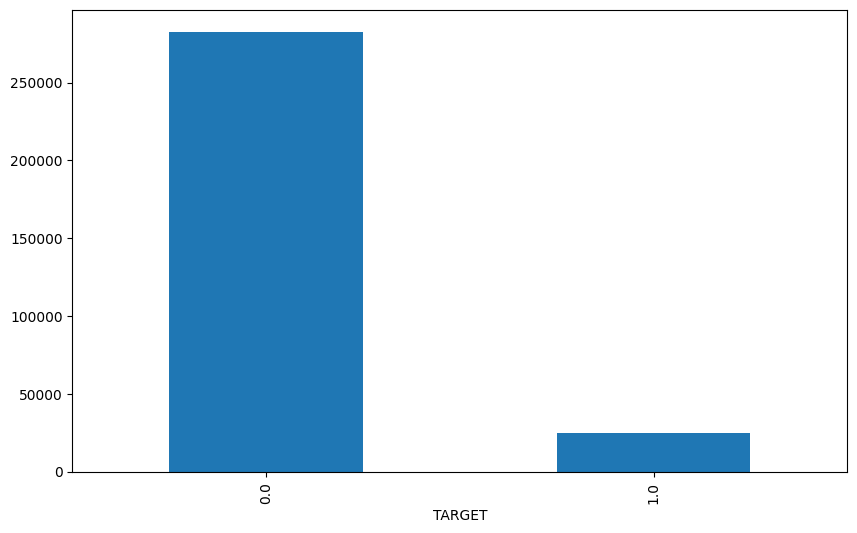

In [15]:
yflag = 'TARGET'
plt.figure(figsize=(10,6))
train_df['TARGET'].value_counts(dropna=False).plot.bar()

In [16]:
train_df['TARGET'] = train_df['TARGET'].map({0.0:0,1.0:1})
train_df['TARGET'].value_counts(dropna=False)

TARGET
0    282682
1     24825
Name: count, dtype: int64

In [17]:
col = train_df.columns.difference([yflag,'SK_ID_CURR'])
# 筛选float的数值类型变量
num_list = train_df[col].select_dtypes(include=['float','int']).columns.tolist()
# 筛选int字符型的数值类型变量
int_list = train_df[col].select_dtypes(include=['int']).columns.tolist()
print('float&int型变量共',len(num_list))
print('int类型变量共',len(int_list))

float&int型变量共 559
int类型变量共 55


**IV_Calculate and Feature Selection**


In [18]:
def cal_iv(df0, var_iv, y_flag, breaks_list, stop_limit0):
    """
    分箱并计算IV值
    :param df0: DF格式的数据
    :param var_iv: 需要计算iv的列的列表
    :param y_flag: y标签
    :return iv_df: variable和iv值
    :return bins_base: 字典，分箱值
    """
    iv_list = []
    bins_base = sc.woebin(df0[var_iv + [y_flag]], y=y_flag, breaks_list=breaks_list, method='tree', stop_limit=stop_limit0)
    # 分箱可视化图
    # bins_show = sc.woebin_plot(bins_base)
    for col, iv_df_i in bins_base.items():
        iv_df_i['bad_distr'] = iv_df_i['bad']/iv_df_i['bad'].sum() #边际坏占比
        iv_df_i['good_distr'] = iv_df_i['good']/iv_df_i['good'].sum() #边际好占比
        iv_df_i = iv_df_i.rename(columns={'variable':'变量名','bin':'分箱','count':'分箱客户数','count_distr':'分箱客户数占比',
                                         'good':'好客户数','bad':'坏客户数','badprob':'区间坏账率','bad_distr':'边际坏客户占比',
                                         'good_distr':'边际好客户占比'})
        iv_df_i = iv_df_i[['变量名','分箱','分箱客户数','好客户数','坏客户数','分箱客户数占比','边际好客户占比','边际坏客户占比',
                           '区间坏账率','woe','bin_iv','total_iv']]
        bins_base[col] = iv_df_i
        iv_list.append((col,iv_df_i['total_iv'][0])) 
    iv_df = pd.DataFrame.from_records(iv_list,columns=['variable','iv_train'])
    iv_df = iv_df.sort_values(by=['iv_train'], ascending=False)
    return iv_df, bins_base

In [19]:
iv_table, bins_df = cal_iv(train_df, num_list, yflag ,breaks_list={}, stop_limit0=0)

[INFO] creating woe binning ...
Binning on 307507 rows and 560 columns in 00:15:05


In [20]:
iv_table[iv_table['iv_train']>0.05]

,variable,iv_train
543,nn_oof_single_past,0.633566
194,prapp_preds_TARGET_mean.1,0.402925
383,buro_preds_TARGET_mean,0.363674
279,prapp_preds_TARGET_median.1,0.348302
76,EXT_SOURCE_3,0.328647
...,...,...
330,REGION_RATING_CLIENT_W_CITY,0.051204
181,CLOSED_AMT_CREDIT_SUM_MEDIAN,0.050860
343,BURO_DAYS_CREDIT_UPDATE_VAR,0.050420
512,CLOSED_DAYS_CREDIT_MAX,0.050401


In [21]:
bins_df['INCOME_PER_CHILD']

,变量名,分箱,分箱客户数,好客户数,坏客户数,分箱客户数占比,边际好客户占比,边际坏客户占比,区间坏账率,woe,bin_iv,total_iv
0,INCOME_PER_CHILD,"[-inf,40000.0)",16247,14614,1633,0.052835,0.051698,0.065780,0.100511,0.240910,0.003393,0.012417
1,INCOME_PER_CHILD,"[40000.0,60000.0)",29216,26606,2610,0.095009,0.094120,0.105136,0.089335,0.110685,0.001219,0.012417
2,INCOME_PER_CHILD,"[60000.0,80000.0)",36512,33409,3103,0.118736,0.118186,0.124995,0.084986,0.056015,0.000381,0.012417
3,INCOME_PER_CHILD,"[80000.0,160000.0)",136337,125314,11023,0.443362,0.443304,0.444028,0.080851,0.001633,0.000001,0.012417
4,INCOME_PER_CHILD,"[160000.0,220000.0)",41462,38186,3276,0.134833,0.135085,0.131964,0.079012,-0.023374,0.000073,0.012417
5,INCOME_PER_CHILD,"[220000.0,240000.0)",16082,14923,1159,0.052298,0.052791,0.046687,0.072068,-0.122875,0.000750,0.012417
6,INCOME_PER_CHILD,"[240000.0,300000.0)",16132,15021,1111,0.052461,0.053137,0.044753,0.068869,-0.171717,0.001440,0.012417
7,INCOME_PER_CHILD,"[300000.0,inf)",15519,14609,910,0.050467,0.051680,0.036657,0.058638,-0.343477,0.005160,0.012417


In [22]:
iv_select = iv_table[iv_table['iv_train']>0.02]
cols =iv_select["variable"].tolist()
cols = cols+["TARGET"]
new_df = train_df[cols]
# new_df.to_csv("selected_features.csv", index=False)
new_df.shape

(307507, 315)

In [23]:
test = test_df.reset_index()
test_id = test['SK_ID_CURR']
train_data = new_df.copy()
features = new_df.columns.difference(["TARGET"]).tolist()
X = train_data[features].values
y = train_data["TARGET"].astype('int32')
test_data = test[cols]
X_test = test_data[features].values
print(train_data.shape)
print(test_data.shape)

(307507, 315)
(48744, 315)


**Model Training**

In [24]:
features = new_df.columns.difference(["TARGET"]).tolist()
X = train_data[features].values
y = train_data["TARGET"].astype('int32')
X_test = test_data[features].values
train = train_df[train_df['TARGET'].isnull()==False]
test = train_df[train_df['TARGET'].isnull()==True]

In [25]:
def fit_lgbm_with_pruning(trial, train, val, devices=(-1,), seed=42, cat_features=None, num_rounds=200):
    """
    训练LightGBM模型（适配 LightGBM v4+: 用 callbacks 实现早停与日志；支持 Optuna 剪枝）
    """

    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'auc'

    # ---- Optuna 采样（推荐的 API，避免弃用警告）----
    params = {
        'objective': 'binary',
        'boosting': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2, log=True),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.1, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 10.0, log=True),
        'bagging_freq': trial.suggest_int('bagging_freq', 2, 10),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'max_depth': trial.suggest_int('max_depth', 2, 4),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 2.0, 5.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 2.0, 10.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 500, 5000),
        'max_bin': trial.suggest_int('max_bin', 2, 30),
        'metric': metric,
        'verbosity': -1,
        'seed': seed,
    }

    # ---- 设备选择 ----
    device = devices[0]
    if device != -1:
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    # ---- 数据集 ----
    dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    dvalid = lgb.Dataset(X_valid,  label=y_valid,  categorical_feature=cat_features)

    # 起固定名字，后续 best_score/剪枝都用 'valid'
    valid_sets = [dtrain, dvalid]
    valid_names = ['training', 'valid']

    # ---- callbacks：早停 + 日志 + 剪枝 ----
    early_stop_rounds = 100
    log_period = 100
    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, metric=metric, valid_name='valid')

    callbacks = [
        lgb.early_stopping(stopping_rounds=early_stop_rounds),
        lgb.log_evaluation(period=log_period),
        pruning_cb,
    ]

    print('training LGB:')
    model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=num_rounds,
        valid_sets=valid_sets,
        valid_names=valid_names,
        callbacks=callbacks
    )

    # 预测
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)

    # 记录分数（按我们给的 valid 名称取）
    # model.best_score 结构：{'training': {'auc': ...}, 'valid': {'auc': ...}}
    print('best_score', model.best_score)
    log = {
        'train/auc': model.best_score['training'][metric],
        'valid/auc': model.best_score['valid'][metric],
    }
    return model, y_pred_valid, log



def objective_with_prune(trial: Trial, fast_check=False):
    """
    目标函数
    """
    folds = 5
    seed = 42
    shuffle = True
    kf = StratifiedKFold(n_splits=folds, shuffle=shuffle, random_state=seed) # 5折Kfold

    X_train, y_train = X, y
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()

    models0 = [] # 模型对象列表
    valid_score = 0 
    
    # 5折交叉验证
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_data = X_train[train_idx, :], y_train[train_idx]
        valid_data = X_train[valid_idx, :], y_train[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
        model, y_pred_valid, log = fit_lgbm_with_pruning(trial, train_data,
                                                         valid_data,
                                                         num_rounds=200)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models0.append(model)
        gc.collect()
        valid_score += log["valid/auc"] 
        if fast_check:
            break
    valid_score /= len(models0)
    return valid_score

study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize")
study.optimize(objective_with_prune, n_trials=50)

[I 2025-10-15 15:54:07,561] A new study created in memory with name: no-name-1f3a6e5c-746b-496a-a060-2a03b7304b75


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.780226	valid's auc: 0.77607
[200]	training's auc: 0.786981	valid's auc: 0.781527
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.786981	valid's auc: 0.781527
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.7869814626015174)]), 'valid': OrderedDict([('auc', 0.7815267959609229)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.778033	valid's auc: 0.782575
[200]	training's auc: 0.784677	valid's auc: 0.789462
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.784677	valid's auc: 0.789462
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.7846770289281153)]), 'valid': OrderedDict([('auc', 0.7894622992035392)])})
train 246006 valid 61501
training LGB:
Training

[I 2025-10-15 15:55:58,497] Trial 0 finished with value: 0.7840559728479592 and parameters: {'num_leaves': 2, 'learning_rate': 0.1628801346586687, 'lambda_l1': 2.2982771847087946, 'lambda_l2': 0.9121895932560898, 'bagging_freq': 4, 'bagging_fraction': 0.5788539819791355, 'feature_fraction': 0.687047845222509, 'max_depth': 3, 'min_sum_hessian_in_leaf': 2.143223368683566, 'min_split_gain': 3.3768686504709295, 'min_data_in_leaf': 3861, 'max_bin': 17}. Best is trial 0 with value: 0.7840559728479592.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.7864434472809673)]), 'valid': OrderedDict([('auc', 0.7815219840140357)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.795885	valid's auc: 0.78651
[200]	training's auc: 0.805378	valid's auc: 0.791198
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.805378	valid's auc: 0.791198
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8053782371045571)]), 'valid': OrderedDict([('auc', 0.7911975333783591)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.79451	valid's auc: 0.793578
[200]	training's auc: 0.803535	valid's auc: 0.79818
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.803535	valid's auc: 0.79818
best_score defaultdict(<class 'collections.Ordered

[I 2025-10-15 15:58:04,377] Trial 1 finished with value: 0.7929218173329626 and parameters: {'num_leaves': 10, 'learning_rate': 0.11278259533951628, 'lambda_l1': 0.3204936606144263, 'lambda_l2': 0.2545308521342491, 'bagging_freq': 4, 'bagging_fraction': 0.7596117546688642, 'feature_fraction': 0.8971267471982048, 'max_depth': 3, 'min_sum_hessian_in_leaf': 3.7690154479208475, 'min_split_gain': 4.608264298450646, 'min_data_in_leaf': 1118, 'max_bin': 16}. Best is trial 1 with value: 0.7929218173329626.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8059804147681012)]), 'valid': OrderedDict([('auc', 0.7913932264780875)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.772692	valid's auc: 0.766079
Early stopping, best iteration is:
[88]	training's auc: 0.772692	valid's auc: 0.766079
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.7726916009403818)]), 'valid': OrderedDict([('auc', 0.766078544647775)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.770899	valid's auc: 0.771694
Early stopping, best iteration is:
[77]	training's auc: 0.770899	valid's auc: 0.771694
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.7708985517962891)]), 'valid': OrderedDict([('auc', 0.7716944037628238)])})
train 246006

[I 2025-10-15 16:00:46,866] Trial 2 finished with value: 0.7679981530949497 and parameters: {'num_leaves': 5, 'learning_rate': 0.19942627005125105, 'lambda_l1': 0.9201994816533315, 'lambda_l2': 0.5532802231935925, 'bagging_freq': 9, 'bagging_fraction': 0.7890137542833551, 'feature_fraction': 0.46281124199623763, 'max_depth': 3, 'min_sum_hessian_in_leaf': 2.1394970353151885, 'min_split_gain': 8.670606370122568, 'min_data_in_leaf': 2727, 'max_bin': 4}. Best is trial 1 with value: 0.7929218173329626.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.792363	valid's auc: 0.783462
[200]	training's auc: 0.800667	valid's auc: 0.788302
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.800667	valid's auc: 0.788302
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8006667457539619)]), 'valid': OrderedDict([('auc', 0.7883019365389519)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.790104	valid's auc: 0.791253
[200]	training's auc: 0.798374	valid's auc: 0.797596
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.798374	valid's auc: 0.797596
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.7983742310614149)]), 'valid': OrderedDict([('auc', 0.7975958493685595)])})
train 246006 valid 61501
training LGB:
Trainin

[I 2025-10-15 16:04:10,371] Trial 3 finished with value: 0.7914594549119149 and parameters: {'num_leaves': 10, 'learning_rate': 0.08956777811421235, 'lambda_l1': 8.896660727867916, 'lambda_l2': 3.490214798346491, 'bagging_freq': 8, 'bagging_fraction': 0.8332119324900177, 'feature_fraction': 0.5582965764203494, 'max_depth': 3, 'min_sum_hessian_in_leaf': 2.448018748912628, 'min_split_gain': 6.197696019927, 'min_data_in_leaf': 4385, 'max_bin': 29}. Best is trial 1 with value: 0.7929218173329626.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8003811345073987)]), 'valid': OrderedDict([('auc', 0.7890318154633018)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.782239	valid's auc: 0.777492
[200]	training's auc: 0.79018	valid's auc: 0.783785
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.79018	valid's auc: 0.783785
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.7901797481439256)]), 'valid': OrderedDict([('auc', 0.7837850859050302)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.780533	valid's auc: 0.783163
[200]	training's auc: 0.788331	valid's auc: 0.790168
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.788331	valid's auc: 0.790168
best_score defaultdict(<class 'collections.Order

[I 2025-10-15 16:06:19,626] Trial 4 finished with value: 0.7855243434780376 and parameters: {'num_leaves': 9, 'learning_rate': 0.06884908046197354, 'lambda_l1': 5.386987348739207, 'lambda_l2': 5.852142483005456, 'bagging_freq': 10, 'bagging_fraction': 0.9685464768990265, 'feature_fraction': 0.8165152038614982, 'max_depth': 2, 'min_sum_hessian_in_leaf': 2.14183597833502, 'min_split_gain': 7.578293601669682, 'min_data_in_leaf': 2823, 'max_bin': 22}. Best is trial 1 with value: 0.7929218173329626.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.7901574577444372)]), 'valid': OrderedDict([('auc', 0.7830894868864847)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:06:27,751] Trial 5 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.792474	valid's auc: 0.783958
[200]	training's auc: 0.797185	valid's auc: 0.786595
Did not meet early stopping. Best iteration is:
[160]	training's auc: 0.797185	valid's auc: 0.786595
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.7971849300316792)]), 'valid': OrderedDict([('auc', 0.7865945571099863)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.790706	valid's auc: 0.791922
[200]	training's auc: 0.794936	valid's auc: 0.795316
Did not meet early stopping. Best iteration is:
[160]	training's auc: 0.794936	valid's auc: 0.795316
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.7949361335579573)]), 'valid': OrderedDict([('auc', 0.795315693146149)])})
train 246006 valid 61501
training LGB:
Training

[I 2025-10-15 16:08:45,293] Trial 6 finished with value: 0.7896640327029603 and parameters: {'num_leaves': 6, 'learning_rate': 0.12486658351638635, 'lambda_l1': 9.409310464312592, 'lambda_l2': 2.3349253878590592, 'bagging_freq': 9, 'bagging_fraction': 0.9516088082927923, 'feature_fraction': 0.6472832400626295, 'max_depth': 3, 'min_sum_hessian_in_leaf': 2.340534216924779, 'min_split_gain': 6.763750472704012, 'min_data_in_leaf': 565, 'max_bin': 11}. Best is trial 1 with value: 0.7929218173329626.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.7973172839736744)]), 'valid': OrderedDict([('auc', 0.7874470949968015)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:08:53,604] Trial 7 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.796491	valid's auc: 0.786696
[200]	training's auc: 0.803705	valid's auc: 0.790139
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.803705	valid's auc: 0.790139
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8037047261138166)]), 'valid': OrderedDict([('auc', 0.7901391135974355)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.794277	valid's auc: 0.795057
[200]	training's auc: 0.801886	valid's auc: 0.798212
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.801886	valid's auc: 0.798212
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8018859449875276)]), 'valid': OrderedDict([('auc', 0.7982117816027615)])})
train 246006 valid 61501
training LGB:
Trainin

[I 2025-10-15 16:10:45,107] Trial 8 finished with value: 0.7927871211668359 and parameters: {'num_leaves': 5, 'learning_rate': 0.17799027147038537, 'lambda_l1': 0.3257228833234632, 'lambda_l2': 0.1972072594922827, 'bagging_freq': 10, 'bagging_fraction': 0.5758069324829704, 'feature_fraction': 0.8369976372682881, 'max_depth': 3, 'min_sum_hessian_in_leaf': 2.7171350931308296, 'min_split_gain': 2.617552574092265, 'min_data_in_leaf': 3295, 'max_bin': 20}. Best is trial 1 with value: 0.7929218173329626.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8044251875747747)]), 'valid': OrderedDict([('auc', 0.79072266299928)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:10:53,345] Trial 9 pruned. Trial was pruned at iteration 6.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:11:01,028] Trial 10 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:11:08,945] Trial 11 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.801002	valid's auc: 0.78828
[200]	training's auc: 0.807864	valid's auc: 0.789753
Did not meet early stopping. Best iteration is:
[188]	training's auc: 0.80734	valid's auc: 0.789853
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8073399092905239)]), 'valid': OrderedDict([('auc', 0.7898530244459684)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.798402	valid's auc: 0.796525
[200]	training's auc: 0.805413	valid's auc: 0.797916
Did not meet early stopping. Best iteration is:
[189]	training's auc: 0.80496	valid's auc: 0.797934
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8049598316919045)]), 'valid': OrderedDict([('auc', 0.7979337257614237)])})
train 246006 valid 61501
training LGB:
Training u

[I 2025-10-15 16:12:56,829] Trial 12 finished with value: 0.7924076093420785 and parameters: {'num_leaves': 7, 'learning_rate': 0.19647553656087194, 'lambda_l1': 0.38258456669354035, 'lambda_l2': 0.33919583687478794, 'bagging_freq': 4, 'bagging_fraction': 0.5057589887637018, 'feature_fraction': 0.8319335514792452, 'max_depth': 3, 'min_sum_hessian_in_leaf': 2.9272066317779766, 'min_split_gain': 4.554498144880043, 'min_data_in_leaf': 1668, 'max_bin': 18}. Best is trial 1 with value: 0.7929218173329626.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8067081787631085)]), 'valid': OrderedDict([('auc', 0.7902648417228224)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.796167	valid's auc: 0.78512
[200]	training's auc: 0.803903	valid's auc: 0.788786
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.803903	valid's auc: 0.788786
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8039026255935527)]), 'valid': OrderedDict([('auc', 0.7887856201824965)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.793922	valid's auc: 0.793684
[200]	training's auc: 0.801293	valid's auc: 0.797794
Did not meet early stopping. Best iteration is:
[189]	training's auc: 0.800737	valid's auc: 0.797815
best_score defaultdict(<class 'collections.Orde

[I 2025-10-15 16:14:52,101] Trial 13 finished with value: 0.7921996678936774 and parameters: {'num_leaves': 10, 'learning_rate': 0.12944326372577084, 'lambda_l1': 0.543819013696297, 'lambda_l2': 0.16320060615419252, 'bagging_freq': 7, 'bagging_fraction': 0.6506491679215456, 'feature_fraction': 0.9558439452035696, 'max_depth': 3, 'min_sum_hessian_in_leaf': 3.7719948195920376, 'min_split_gain': 4.174097285852428, 'min_data_in_leaf': 3557, 'max_bin': 13}. Best is trial 1 with value: 0.7929218173329626.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8035691956311695)]), 'valid': OrderedDict([('auc', 0.7912601632967492)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:14:59,500] Trial 14 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:15:07,065] Trial 15 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:15:14,712] Trial 16 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:15:22,278] Trial 17 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:15:29,793] Trial 18 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:15:37,283] Trial 19 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.801478	valid's auc: 0.789382
[200]	training's auc: 0.809271	valid's auc: 0.792098
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.809271	valid's auc: 0.792098
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8092712675745185)]), 'valid': OrderedDict([('auc', 0.792097670231408)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.798539	valid's auc: 0.796068
[200]	training's auc: 0.806825	valid's auc: 0.799152
Did not meet early stopping. Best iteration is:
[190]	training's auc: 0.806163	valid's auc: 0.799159
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8061630965722003)]), 'valid': OrderedDict([('auc', 0.799158686214293)])})
train 246006 valid 61501
training LGB:
Training 

[I 2025-10-15 16:17:39,708] Trial 20 finished with value: 0.7939025815576662 and parameters: {'num_leaves': 7, 'learning_rate': 0.17941269636981214, 'lambda_l1': 0.7422705241983562, 'lambda_l2': 0.6123796811316293, 'bagging_freq': 3, 'bagging_fraction': 0.7134902724105877, 'feature_fraction': 0.9991813161497434, 'max_depth': 3, 'min_sum_hessian_in_leaf': 4.966774240609794, 'min_split_gain': 3.8460950882995504, 'min_data_in_leaf': 3148, 'max_bin': 26}. Best is trial 20 with value: 0.7939025815576662.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8091844876585134)]), 'valid': OrderedDict([('auc', 0.7915094853161319)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.800639	valid's auc: 0.788224
[200]	training's auc: 0.808603	valid's auc: 0.79042
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.808603	valid's auc: 0.79042
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8086028641490678)]), 'valid': OrderedDict([('auc', 0.7904204290745906)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.79844	valid's auc: 0.797097
[200]	training's auc: 0.806474	valid's auc: 0.800268
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.806474	valid's auc: 0.800268
best_score defaultdict(<class 'collections.Ordere

[I 2025-10-15 16:19:41,245] Trial 21 finished with value: 0.7938388189760375 and parameters: {'num_leaves': 7, 'learning_rate': 0.17268605495852812, 'lambda_l1': 0.33850667025750064, 'lambda_l2': 0.6265418805453724, 'bagging_freq': 3, 'bagging_fraction': 0.7128620526362355, 'feature_fraction': 0.9860307878377191, 'max_depth': 3, 'min_sum_hessian_in_leaf': 4.9990213922620725, 'min_split_gain': 3.877219645717136, 'min_data_in_leaf': 3201, 'max_bin': 26}. Best is trial 20 with value: 0.7939025815576662.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8084217049793488)]), 'valid': OrderedDict([('auc', 0.791941004606891)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.799685	valid's auc: 0.787789
[200]	training's auc: 0.808155	valid's auc: 0.79066
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.808155	valid's auc: 0.79066
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8081547457821056)]), 'valid': OrderedDict([('auc', 0.7906597647173492)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.797743	valid's auc: 0.795562
[200]	training's auc: 0.806125	valid's auc: 0.79884
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.806125	valid's auc: 0.79884
best_score defaultdict(<class 'collections.OrderedD

[I 2025-10-15 16:21:42,562] Trial 22 finished with value: 0.7935462587429613 and parameters: {'num_leaves': 8, 'learning_rate': 0.14963046506545535, 'lambda_l1': 0.8480943533472511, 'lambda_l2': 0.6406693249397022, 'bagging_freq': 3, 'bagging_fraction': 0.7140854223438806, 'feature_fraction': 0.9945452201849208, 'max_depth': 3, 'min_sum_hessian_in_leaf': 4.941587086373919, 'min_split_gain': 4.101273062537142, 'min_data_in_leaf': 2955, 'max_bin': 26}. Best is trial 20 with value: 0.7939025815576662.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8083464552647677)]), 'valid': OrderedDict([('auc', 0.7918734808581537)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.799095	valid's auc: 0.787861
[200]	training's auc: 0.806184	valid's auc: 0.791393
Did not meet early stopping. Best iteration is:
[195]	training's auc: 0.806117	valid's auc: 0.791448
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8061173679952999)]), 'valid': OrderedDict([('auc', 0.7914479054711313)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.796829	valid's auc: 0.795909
[200]	training's auc: 0.804094	valid's auc: 0.800124
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.804094	valid's auc: 0.800124
best_score defaultdict(<class 'collections.Ord

[I 2025-10-15 16:23:43,531] Trial 23 finished with value: 0.7938694669440736 and parameters: {'num_leaves': 7, 'learning_rate': 0.14368216426122757, 'lambda_l1': 0.7220986188138794, 'lambda_l2': 1.0903169379967599, 'bagging_freq': 3, 'bagging_fraction': 0.7035624888608945, 'feature_fraction': 0.9996519571994871, 'max_depth': 3, 'min_sum_hessian_in_leaf': 4.9816850081785224, 'min_split_gain': 5.358112740699693, 'min_data_in_leaf': 2968, 'max_bin': 26}. Best is trial 20 with value: 0.7939025815576662.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8065164390098175)]), 'valid': OrderedDict([('auc', 0.7922206827444012)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.80109	valid's auc: 0.788296
[200]	training's auc: 0.805824	valid's auc: 0.790374
Did not meet early stopping. Best iteration is:
[156]	training's auc: 0.805418	valid's auc: 0.790393
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8054183930552626)]), 'valid': OrderedDict([('auc', 0.7903926028282845)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.798817	valid's auc: 0.796945
[200]	training's auc: 0.804325	valid's auc: 0.799559
Did not meet early stopping. Best iteration is:
[190]	training's auc: 0.804291	valid's auc: 0.799614
best_score defaultdict(<class 'collections.Orde

[I 2025-10-15 16:25:41,455] Trial 24 finished with value: 0.7932273655911172 and parameters: {'num_leaves': 7, 'learning_rate': 0.17551676455260773, 'lambda_l1': 2.6650896813984275, 'lambda_l2': 1.213949678339392, 'bagging_freq': 3, 'bagging_fraction': 0.7031380898516422, 'feature_fraction': 0.9949067058849044, 'max_depth': 3, 'min_sum_hessian_in_leaf': 4.975299868417147, 'min_split_gain': 5.708421831285195, 'min_data_in_leaf': 2320, 'max_bin': 26}. Best is trial 20 with value: 0.7939025815576662.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8050144418729609)]), 'valid': OrderedDict([('auc', 0.7910544641698056)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.801293	valid's auc: 0.789268
[200]	training's auc: 0.80385	valid's auc: 0.790823
Did not meet early stopping. Best iteration is:
[143]	training's auc: 0.80385	valid's auc: 0.790823
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8038501042373668)]), 'valid': OrderedDict([('auc', 0.7908228961308497)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.798629	valid's auc: 0.795683
[200]	training's auc: 0.801806	valid's auc: 0.797648
Did not meet early stopping. Best iteration is:
[149]	training's auc: 0.801806	valid's auc: 0.797648
best_score defaultdict(<class 'collections.Order

[I 2025-10-15 16:27:44,839] Trial 25 finished with value: 0.7930768323231073 and parameters: {'num_leaves': 7, 'learning_rate': 0.1790797868594109, 'lambda_l1': 0.7239217680035381, 'lambda_l2': 0.9087215392574699, 'bagging_freq': 2, 'bagging_fraction': 0.8024508713984388, 'feature_fraction': 0.9497175002033085, 'max_depth': 3, 'min_sum_hessian_in_leaf': 4.677463123168174, 'min_split_gain': 6.904441708473126, 'min_data_in_leaf': 3522, 'max_bin': 30}. Best is trial 20 with value: 0.7939025815576662.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8036742122737613)]), 'valid': OrderedDict([('auc', 0.7914444161343925)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:27:53,028] Trial 26 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:28:00,849] Trial 27 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.802265	valid's auc: 0.789365
[200]	training's auc: 0.808902	valid's auc: 0.792167
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.808902	valid's auc: 0.792167
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8089018691209022)]), 'valid': OrderedDict([('auc', 0.79216655363924)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.799511	valid's auc: 0.796685
[200]	training's auc: 0.805792	valid's auc: 0.799541
Did not meet early stopping. Best iteration is:
[197]	training's auc: 0.80568	valid's auc: 0.799683
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8056803710565704)]), 'valid': OrderedDict([('auc', 0.7996833486456062)])})
train 246006 valid 61501
training LGB:
Training u

[I 2025-10-15 16:30:05,639] Trial 28 finished with value: 0.7941535872554286 and parameters: {'num_leaves': 8, 'learning_rate': 0.17394485982143426, 'lambda_l1': 0.48042040909566036, 'lambda_l2': 3.7922237067444557, 'bagging_freq': 2, 'bagging_fraction': 0.7668808692515962, 'feature_fraction': 0.9530037214990389, 'max_depth': 3, 'min_sum_hessian_in_leaf': 4.839712174761281, 'min_split_gain': 5.077954923075134, 'min_data_in_leaf': 2615, 'max_bin': 24}. Best is trial 28 with value: 0.7941535872554286.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8079319111986483)]), 'valid': OrderedDict([('auc', 0.7915623386629856)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:30:13,357] Trial 29 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.803179	valid's auc: 0.790118


[I 2025-10-15 16:30:36,740] Trial 30 pruned. Trial was pruned at iteration 188.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.800241	valid's auc: 0.787913
[200]	training's auc: 0.808827	valid's auc: 0.790865
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.808827	valid's auc: 0.790865
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.808827215122809)]), 'valid': OrderedDict([('auc', 0.7908647833417148)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.798168	valid's auc: 0.796356
[200]	training's auc: 0.806914	valid's auc: 0.800046
Did not meet early stopping. Best iteration is:
[186]	training's auc: 0.805993	valid's auc: 0.800185
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8059932842150465)]), 'valid': OrderedDict([('auc', 0.8001853361239378)])})
train 246006 valid 61501
training LGB:
Training

[I 2025-10-15 16:32:39,959] Trial 31 finished with value: 0.7936780674258201 and parameters: {'num_leaves': 7, 'learning_rate': 0.1678402323844264, 'lambda_l1': 0.6854666896500581, 'lambda_l2': 0.8773382258212937, 'bagging_freq': 3, 'bagging_fraction': 0.7278717683459197, 'feature_fraction': 0.965940040164086, 'max_depth': 3, 'min_sum_hessian_in_leaf': 4.837792637899831, 'min_split_gain': 2.842958305576198, 'min_data_in_leaf': 3643, 'max_bin': 25}. Best is trial 28 with value: 0.7941535872554286.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8088918367924387)]), 'valid': OrderedDict([('auc', 0.7919712645373422)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:32:50,363] Trial 32 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.801693	valid's auc: 0.789472
[200]	training's auc: 0.806469	valid's auc: 0.791291
Did not meet early stopping. Best iteration is:
[187]	training's auc: 0.806239	valid's auc: 0.791375
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.806239178683783)]), 'valid': OrderedDict([('auc', 0.7913752886224941)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.798488	valid's auc: 0.79602
[200]	training's auc: 0.802816	valid's auc: 0.797895
Did not meet early stopping. Best iteration is:
[163]	training's auc: 0.802816	valid's auc: 0.797895
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8028155611467364)]), 'valid': OrderedDict([('auc', 0.7978947027551457)])})
train 246006 valid 61501
training LGB:
Training 

[I 2025-10-15 16:34:44,161] Trial 33 finished with value: 0.7930625645077256 and parameters: {'num_leaves': 8, 'learning_rate': 0.18316966833164605, 'lambda_l1': 0.3593167937837444, 'lambda_l2': 4.046355710412208, 'bagging_freq': 4, 'bagging_fraction': 0.6489588838806752, 'feature_fraction': 0.9941049198456955, 'max_depth': 3, 'min_sum_hessian_in_leaf': 4.951030157790464, 'min_split_gain': 5.6402285809501835, 'min_data_in_leaf': 3053, 'max_bin': 21}. Best is trial 28 with value: 0.7941535872554286.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8055726171390548)]), 'valid': OrderedDict([('auc', 0.7904616203334193)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:34:53,948] Trial 34 pruned. Trial was pruned at iteration 28.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.803787	valid's auc: 0.789374
[200]	training's auc: 0.810199	valid's auc: 0.7912
Did not meet early stopping. Best iteration is:
[195]	training's auc: 0.810199	valid's auc: 0.7912
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.810198903879479)]), 'valid': OrderedDict([('auc', 0.791199809779766)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.801409	valid's auc: 0.797302
[200]	training's auc: 0.808262	valid's auc: 0.799982
Did not meet early stopping. Best iteration is:
[196]	training's auc: 0.808146	valid's auc: 0.800082
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8081456367158493)]), 'valid': OrderedDict([('auc', 0.8000824670049599)])})
train 246006 valid 61501
training LGB:
Training unti

[I 2025-10-15 16:37:02,790] Trial 35 finished with value: 0.7943966640713775 and parameters: {'num_leaves': 8, 'learning_rate': 0.1968586896571731, 'lambda_l1': 1.01723715206363, 'lambda_l2': 1.1306409221009894, 'bagging_freq': 2, 'bagging_fraction': 0.8175866252072161, 'feature_fraction': 0.9599480347182683, 'max_depth': 3, 'min_sum_hessian_in_leaf': 4.758396451335359, 'min_split_gain': 4.367362998039098, 'min_data_in_leaf': 3288, 'max_bin': 30}. Best is trial 35 with value: 0.7943966640713775.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8103591445514229)]), 'valid': OrderedDict([('auc', 0.7928907474722947)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.802698	valid's auc: 0.788336


[I 2025-10-15 16:37:22,396] Trial 36 pruned. Trial was pruned at iteration 127.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.802066	valid's auc: 0.789071
[200]	training's auc: 0.808562	valid's auc: 0.791159
Did not meet early stopping. Best iteration is:
[184]	training's auc: 0.808188	valid's auc: 0.791193
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8081879853796269)]), 'valid': OrderedDict([('auc', 0.7911931159483988)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.799663	valid's auc: 0.796448
[200]	training's auc: 0.806217	valid's auc: 0.798999
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.806217	valid's auc: 0.798999
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8062174969196144)]), 'valid': OrderedDict([('auc', 0.7989994236144513)])})
train 246006 valid 61501
training LGB:
Trainin

[I 2025-10-15 16:40:40,945] Trial 37 finished with value: 0.7937942708725056 and parameters: {'num_leaves': 9, 'learning_rate': 0.1851967399051144, 'lambda_l1': 1.0180385790285011, 'lambda_l2': 1.230127083843065, 'bagging_freq': 2, 'bagging_fraction': 0.8108211332177541, 'feature_fraction': 0.5250999863498009, 'max_depth': 3, 'min_sum_hessian_in_leaf': 4.157344436268221, 'min_split_gain': 4.495535460890756, 'min_data_in_leaf': 2790, 'max_bin': 28}. Best is trial 35 with value: 0.7943966640713775.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8081682903225482)]), 'valid': OrderedDict([('auc', 0.7911620055543752)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:40:46,711] Trial 38 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:40:54,576] Trial 39 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.804679	valid's auc: 0.789188
[200]	training's auc: 0.810436	valid's auc: 0.790926
Did not meet early stopping. Best iteration is:
[158]	training's auc: 0.810362	valid's auc: 0.790947
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8103623142180543)]), 'valid': OrderedDict([('auc', 0.7909468335407833)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.802303	valid's auc: 0.796722
[200]	training's auc: 0.808835	valid's auc: 0.7993
Did not meet early stopping. Best iteration is:
[168]	training's auc: 0.808827	valid's auc: 0.799303
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8088271209394591)]), 'valid': OrderedDict([('auc', 0.7993030471129058)])})
train 246006 valid 61501
training LGB:
Training 

[I 2025-10-15 16:43:11,709] Trial 40 finished with value: 0.7939558609782719 and parameters: {'num_leaves': 9, 'learning_rate': 0.19978358960499337, 'lambda_l1': 1.790905273479833, 'lambda_l2': 1.0883936503960903, 'bagging_freq': 3, 'bagging_fraction': 0.9972475193817582, 'feature_fraction': 0.9637896357108776, 'max_depth': 3, 'min_sum_hessian_in_leaf': 4.412284289682494, 'min_split_gain': 3.116958421323967, 'min_data_in_leaf': 2111, 'max_bin': 24}. Best is trial 35 with value: 0.7943966640713775.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8105737845621196)]), 'valid': OrderedDict([('auc', 0.7921986165789648)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.803963	valid's auc: 0.788388


[I 2025-10-15 16:43:33,555] Trial 41 pruned. Trial was pruned at iteration 148.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.804627	valid's auc: 0.790559
[200]	training's auc: 0.808423	valid's auc: 0.79171
Did not meet early stopping. Best iteration is:
[148]	training's auc: 0.808398	valid's auc: 0.791747
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8083981814642403)]), 'valid': OrderedDict([('auc', 0.7917465237364454)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.80189	valid's auc: 0.797114
[200]	training's auc: 0.805066	valid's auc: 0.798836
Did not meet early stopping. Best iteration is:
[135]	training's auc: 0.80498	valid's auc: 0.798842
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8049800448192511)]), 'valid': OrderedDict([('auc', 0.798842337667598)])})
train 246006 valid 61501
training LGB:
Training un

[I 2025-10-15 16:45:42,978] Trial 42 finished with value: 0.7938628576961777 and parameters: {'num_leaves': 8, 'learning_rate': 0.19932291949351816, 'lambda_l1': 1.6867564758643836, 'lambda_l2': 2.3513804223964923, 'bagging_freq': 4, 'bagging_fraction': 0.9258549504313809, 'feature_fraction': 0.8910816158218311, 'max_depth': 3, 'min_sum_hessian_in_leaf': 4.808581684347336, 'min_split_gain': 4.964155107021757, 'min_data_in_leaf': 2499, 'max_bin': 30}. Best is trial 35 with value: 0.7943966640713775.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8073471643219836)]), 'valid': OrderedDict([('auc', 0.792655012852811)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:45:51,232] Trial 43 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.801626	valid's auc: 0.789245
[200]	training's auc: 0.805894	valid's auc: 0.791351
Did not meet early stopping. Best iteration is:
[163]	training's auc: 0.805888	valid's auc: 0.791355
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8058881192647099)]), 'valid': OrderedDict([('auc', 0.7913551501292962)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.799691	valid's auc: 0.795928
[200]	training's auc: 0.803814	valid's auc: 0.798345
Did not meet early stopping. Best iteration is:
[161]	training's auc: 0.803814	valid's auc: 0.798345
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8038137191831467)]), 'valid': OrderedDict([('auc', 0.7983446286839295)])})
train 246006 valid 61501
training LGB:
Trainin

[I 2025-10-15 16:47:55,504] Trial 44 finished with value: 0.7929342030271033 and parameters: {'num_leaves': 8, 'learning_rate': 0.17417803986549948, 'lambda_l1': 1.3765666073252225, 'lambda_l2': 1.0503308625109289, 'bagging_freq': 3, 'bagging_fraction': 0.830123718519231, 'feature_fraction': 0.9714242451052896, 'max_depth': 3, 'min_sum_hessian_in_leaf': 4.829709781099211, 'min_split_gain': 5.813314053871258, 'min_data_in_leaf': 2180, 'max_bin': 22}. Best is trial 35 with value: 0.7943966640713775.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8061110520630876)]), 'valid': OrderedDict([('auc', 0.7915433932532682)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:48:03,806] Trial 45 pruned. Trial was pruned at iteration 7.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:48:11,753] Trial 46 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:48:19,525] Trial 47 pruned. Trial was pruned at iteration 5.


train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.802279	valid's auc: 0.789464
[200]	training's auc: 0.808533	valid's auc: 0.79139
Did not meet early stopping. Best iteration is:
[175]	training's auc: 0.807488	valid's auc: 0.791425
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8074878475090074)]), 'valid': OrderedDict([('auc', 0.7914251378946183)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.800025	valid's auc: 0.796773
[200]	training's auc: 0.806645	valid's auc: 0.799016
Did not meet early stopping. Best iteration is:
[191]	training's auc: 0.806293	valid's auc: 0.799227
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8062930021303473)]), 'valid': OrderedDict([('auc', 0.7992267110732376)])})
train 246006 valid 61501
training LGB:
Training

[I 2025-10-15 16:50:20,478] Trial 48 finished with value: 0.7933358088575382 and parameters: {'num_leaves': 9, 'learning_rate': 0.19973887027664539, 'lambda_l1': 1.2531294230017207, 'lambda_l2': 0.31166914393436845, 'bagging_freq': 4, 'bagging_fraction': 0.6807084019062599, 'feature_fraction': 0.6242324247487955, 'max_depth': 3, 'min_sum_hessian_in_leaf': 4.722558948393728, 'min_split_gain': 4.684487806604208, 'min_data_in_leaf': 3021, 'max_bin': 29}. Best is trial 35 with value: 0.7943966640713775.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8074516058475142)]), 'valid': OrderedDict([('auc', 0.7903516030068125)])})
train 246005 valid 61502
training LGB:
Training until validation scores don't improve for 100 rounds


[I 2025-10-15 16:50:28,142] Trial 49 pruned. Trial was pruned at iteration 5.


In [26]:
params = study.best_params
params

{'num_leaves': 8,
 'learning_rate': 0.1968586896571731,
 'lambda_l1': 1.01723715206363,
 'lambda_l2': 1.1306409221009894,
 'bagging_freq': 2,
 'bagging_fraction': 0.8175866252072161,
 'feature_fraction': 0.9599480347182683,
 'max_depth': 3,
 'min_sum_hessian_in_leaf': 4.758396451335359,
 'min_split_gain': 4.367362998039098,
 'min_data_in_leaf': 3288,
 'max_bin': 30}

In [27]:
params['seed'] = 42
params['objective'] = 'binary'
params['boosting'] = "gbdt"
params['metric'] = 'auc'
params['verbosity'] = -1
early_stop = 100
log_period = 20
num_rounds = 200

# 切分
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
print(X_train.shape)
print(X_valid.shape)

# Dataset（如果有类别列，传入列名或索引列表）
d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=None)
d_valid = lgb.Dataset(X_valid,  label=y_valid,  categorical_feature=None)

valid_sets  = [d_train, d_valid]
valid_names = ['training', 'valid']

print('training LGB:')
model = lgb.train(
    params=params,
    train_set=d_train,
    num_boost_round=num_rounds,
    valid_sets=valid_sets,
    valid_names=valid_names,
    callbacks=[
        lgb.early_stopping(stopping_rounds=early_stop),
        lgb.log_evaluation(period=log_period)
    ]
)

print('best iteration', model.best_iteration)

# 预测
y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)

# 分数（用我们起的名字 'training' 和 'valid'）
train_auc = model.best_score['training']['auc']
valid_auc = model.best_score['valid']['auc']
print('best_score', {'training/auc': train_auc, 'valid/auc': valid_auc})


(246005, 314)
(61502, 314)
training LGB:
Training until validation scores don't improve for 100 rounds
[20]	training's auc: 0.781481	valid's auc: 0.776002
[40]	training's auc: 0.791282	valid's auc: 0.783971
[60]	training's auc: 0.796696	valid's auc: 0.787213
[80]	training's auc: 0.801057	valid's auc: 0.789503
[100]	training's auc: 0.803613	valid's auc: 0.790898
[120]	training's auc: 0.805801	valid's auc: 0.791523
[140]	training's auc: 0.807446	valid's auc: 0.791687
[160]	training's auc: 0.808703	valid's auc: 0.791891
[180]	training's auc: 0.809714	valid's auc: 0.792191
[200]	training's auc: 0.810564	valid's auc: 0.7922
Did not meet early stopping. Best iteration is:
[181]	training's auc: 0.809821	valid's auc: 0.792261
best iteration 181
best_score {'training/auc': 0.8098210795377683, 'valid/auc': 0.7922612000437912}


In [28]:
# 通过模型对象预测结果
def pred(X_test, models):
    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)
        y_test_pred_total += y_pred_test
    y_test_pred_total /= len(models)
    return y_test_pred_total

# 可视化特征重要性
def plot_feature_importance(model,features):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=features,
                                 columns=['importance']).sort_values('importance').sort_values(by='importance',ascending=False).head(20)
    fig, ax = plt.subplots(figsize=(15, 10))
    importance_df.plot.barh(ax=ax)
    fig.show()

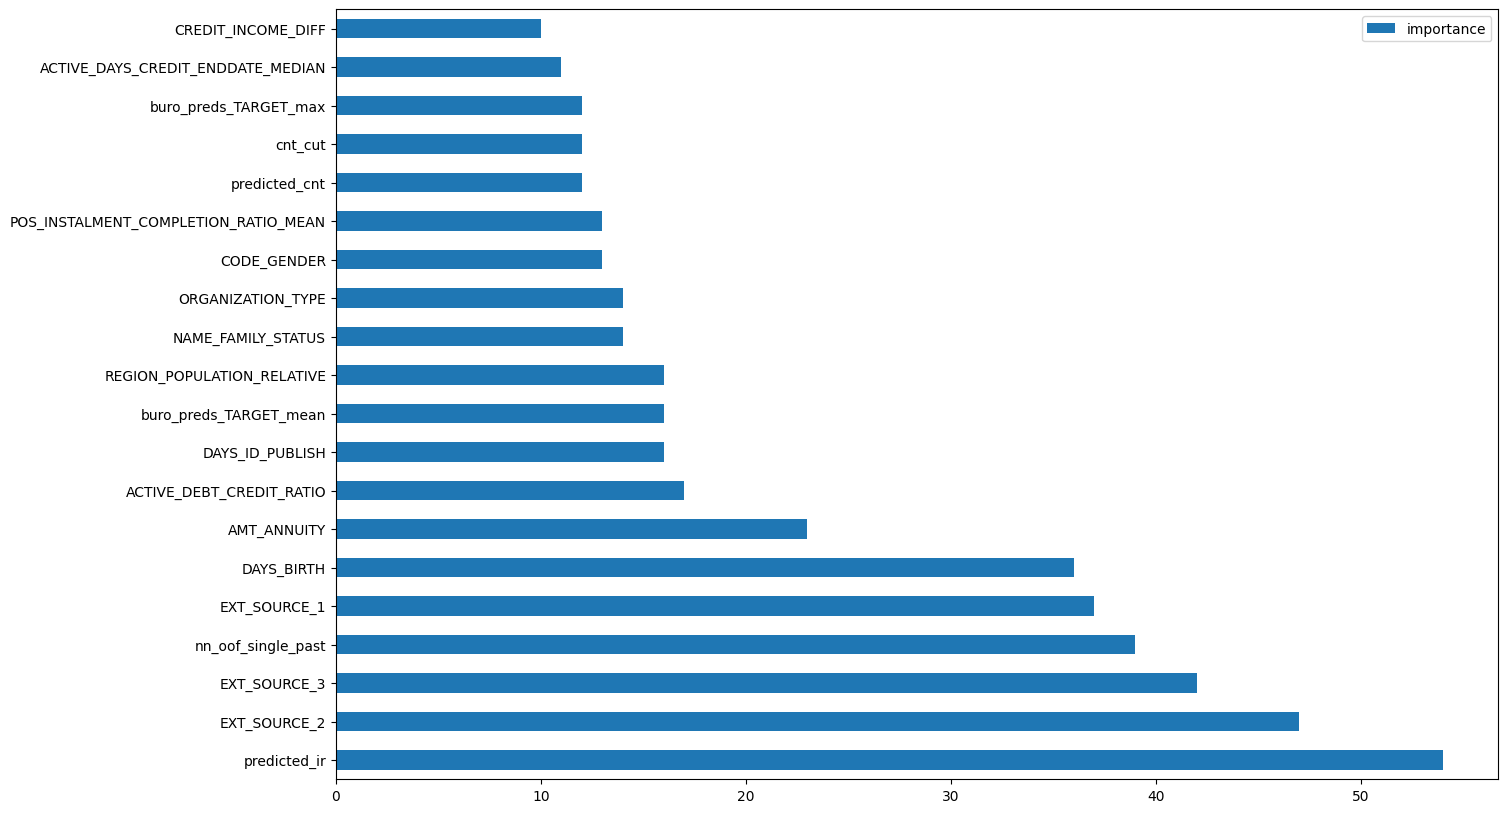

In [29]:
# 展示排名前20的特征重要性
plot_feature_importance(model, features)

In [30]:
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)
# 如果有测试集 ID：
submission = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': y_test_pred})
submission.to_csv('submission1.csv', index=False)

**Method2**

In [31]:
from autogluon.tabular import TabularPredictor,TabularDataset
train_Dataset=TabularDataset(train_data)
test_Dataset=TabularDataset(test_data)
predictor = TabularPredictor(label='TARGET',problem_type='binary',eval_metric='roc_auc').fit(train_Dataset,presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20251015_165057"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       21.11 GB / 31.35 GB (67.3%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optim

In [32]:
y_pred = predictor.predict_proba(test_Dataset)
y_pred = y_pred.drop(y_pred.columns[0], axis=1)
y_pred.index=test_id
y_pred = y_pred.rename(columns={y_pred.columns[0]: 'TARGET'})
y_pred.to_csv('submission2.csv',index=True)